In [1]:
%cd omrtorch

from omrdatasettools import Downloader, OmrDataset
import xmlschema

import os
from PIL import Image

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import draw_bounding_boxes
from contextlib import redirect_stdout

from datasets import models
import datasets

import importlib

from datasets import MuscimaObjects, MuscimaDownloader

/scratch/users/cakarsubasi18/JupyterWorkspace/omrtorch


In [2]:
muscimaroot = MuscimaDownloader.download()

dataset = MuscimaObjects.MuscimaObjects(muscimaroot)

Extracting MuscimaPlusPlus_V2 dataset...
Deleting temporary directory /scratch/users/cakarsubasi18/JupyterWorkspace/omrtorch/MuscimaPpImages
Extracting MuscimaPlusPlus_MeasureAnnotations dataset...


### Test

In [3]:
from visionutils.engine import train_one_epoch, evaluate
import visionutils.utils as utils
import visionutils.transforms as T
from datasets.MuscimaMeasures import get_transform

Initialized module


In [4]:
dataset = MuscimaObjects.MuscimaObjects(muscimaroot, transforms=get_transform(train=True))
dataloader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)

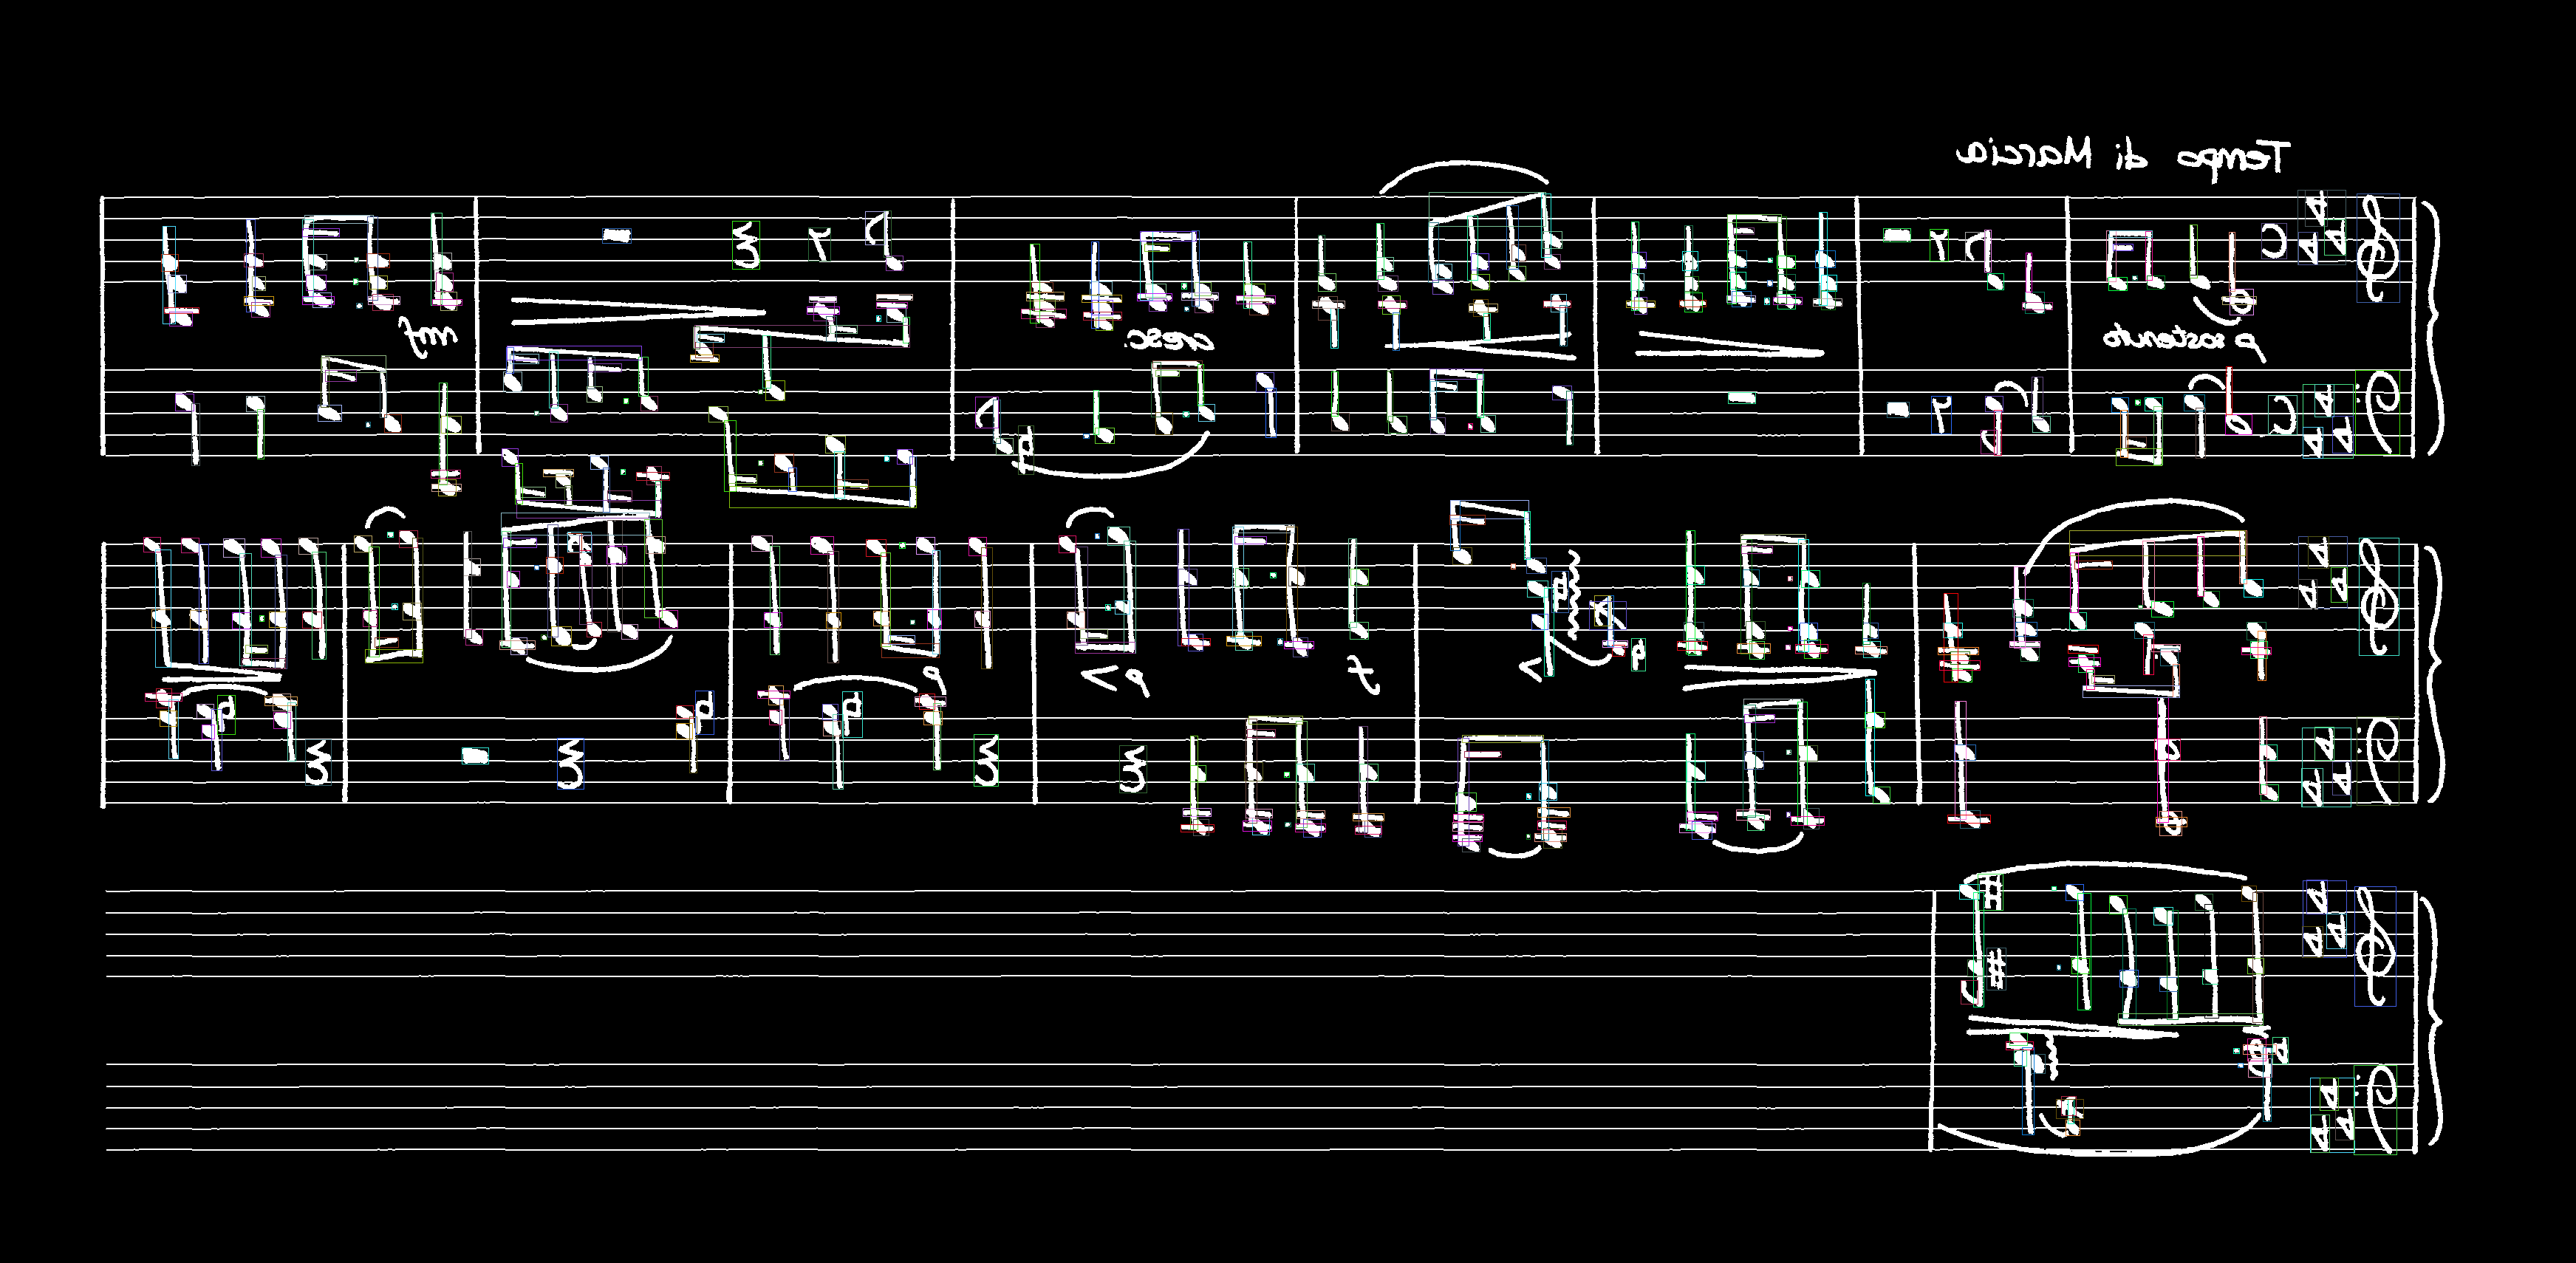

In [5]:
sample_im, sample_ann = dataset[0]
sample_boxes = sample_ann['boxes']

sample_im = (255*sample_im).type(torch.ByteTensor)

sample_im_with_bounding_boxes = draw_bounding_boxes(sample_im, sample_boxes)

sample_im_with_bounding_boxes.shape
Image.fromarray(np.moveaxis(sample_im_with_bounding_boxes.numpy(), 0, -1))

### Model

In [6]:
# Pretrained model
# [0.12, 0.24, 0.91, 4.97] - standard reduced symbols
# [0.34, 0.6, 0.88, 1.21] - pitch info only

In [7]:
label_list_pitch_only = ['noteheadFull', 'noteheadHalf', 'noteheadWhole', 'accidentalSharp', 'accidentalFlat', 'accidentalNatural',
                    'gCflef', 'fClef', 'cClef']

In [13]:
#label_list_pitch_only = None
#aspects = (0.12, 0.24, 0.91, 4.97)
#aspects = (0.5, 1.0, 2.0, 4.0)
aspects = (0.34, 0.6, 0.88, 1.21)

dataset.label_list = label_list_pitch_only

model = models.muscima_fpn_model(num_classes=(len(dataset.label_list) + 1),
                                backbone='resnet50',
                                aspects=aspects,)

In [14]:
#images, targets = next(iter(dataloader))

#images = list(image for image in images)
#targets = [{k: v for k, v in t.items()} for t in targets]
#output = model(images, targets)
#model = models.get_conv_next()

model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x) 

In [15]:
dataset = MuscimaObjects.MuscimaObjects(muscimaroot, label_list_pitch_only, transforms=get_transform(train=True))
dataset_test = MuscimaObjects.MuscimaObjects(muscimaroot, label_list_pitch_only, transforms=get_transform(train=False))

#splits
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-40])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-40:])

print(len(dataset))
print(len(dataset_test))

#dataloaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=2,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=2,
    collate_fn=utils.collate_fn)

100
40


In [16]:
# don't train on login nodes stupid
assert torch.cuda.get_device_name() != "Tesla P4"

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

# optimizer
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.003, momentum=0.9, weight_decay=0.0005)
# Adam is greedier but less numerically stable
optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=0.0005)
#optimizer = torch.optim.RMSprop(params, lr=0.003, weight_decay=0.0)

#lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)
#lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.2, patience=5, threshold=0.01)
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
#lr_scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.000001)
#
total_trainable_params = 0
for p in params:
    num = np.prod(np.asarray(p.shape))
    #print(num)
    total_trainable_params += num
print("Total trainable parameters: ", total_trainable_params)

Total trainable parameters:  41341446


In [17]:
CHECKPOINT_DIR = "checkpoints"
if not os.path.exists(CHECKPOINT_DIR):
    os.mkdir('checkpoints')
LOGDIR = os.path.join(CHECKPOINT_DIR, "log.txt")

num_epochs = 100

run_training_and_validation = True

max_map = 0

if run_training_and_validation:
    with open(LOGDIR, 'w') as log:
        log.write("training for {} epochs\n".format(num_epochs))
    for epoch in range(num_epochs):
        with open(LOGDIR, "a") as log, redirect_stdout(log):
            # train for one epoch, printing every 10 iterations
            train_metrics = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
            # evaluate on the test dataset
            val_metrics = evaluate(model, data_loader_test, device=device)
            # update the learning rate
            lr_scheduler.step()
            #if epoch >= 10:
            #    lr_scheduler2.step()

        print("Epoch [{}]:\n".format(epoch))
        print(train_metrics) # ?
        val_metrics.summarize()
        
        # save and overwrite the best checkpoint
        if val_metrics.coco_eval['bbox'].stats[0] > max_map:
            max_map = val_metrics.coco_eval['bbox'].stats[0]
            torch.save(model, os.path.join(CHECKPOINT_DIR, "checkpoint_best.pt"))
            print("Checkpoint Saved!")

    # save the final epoch as a checkpoint
    torch.save(model, os.path.join(CHECKPOINT_DIR, "checkpoint_{}.pt".format(epoch)))

Epoch [0]:

lr: 0.001000  loss: 1.4906 (1.9089)  loss_classifier: 0.3953 (0.6559)  loss_box_reg: 0.3654 (0.3389)  loss_objectness: 0.2220 (0.3605)  loss_rpn_box_reg: 0.4001 (0.5535)
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.045
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.003
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.032
 

In [18]:

# Since the outputs stop updating when the Jupyter Kernel disconnects, run evaluation one more time
# to print results
evaluate(model, data_loader_test, device=device)


creating index...
index created!
Test:  [ 0/40]  eta: 0:00:45  model_time: 0.1443 (0.1443)  evaluator_time: 0.3529 (0.3529)  time: 1.1384  data: 0.6248  max mem: 8950
Test:  [39/40]  eta: 0:00:00  model_time: 0.1026 (0.1031)  evaluator_time: 0.2764 (0.2898)  time: 0.4077  data: 0.0065  max mem: 8950
Test: Total time: 0:00:17 (0.4302 s / it)
Averaged stats: model_time: 0.1026 (0.1031)  evaluator_time: 0.2764 (0.2898)
Accumulating evaluation results...
DONE (t=0.22s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.015
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.013
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=

###Visualization

In [18]:
def visualize_bboxes(image, target, labels=None, threshold=0.5):
    colors = ['000000', 'red', 'blue', 'green', 'yellow']
    sample_boxes = target['boxes']
    sample_scores = target['scores']
    sample_labels = target['labels']
    idx = torch.where(sample_scores > threshold)
    boxes_sliced = sample_boxes[idx]
    labels_sliced = sample_labels[idx].tolist()
    labels_list_str = None
    if labels is not None:
        labels_list_str = list(labels[val] for val in labels_sliced)
        colors_list = list(colors[val] for val in labels_sliced)
    sample_image = (image*255).type(torch.ByteTensor)

    sample_im_with_bounding_boxes = draw_bounding_boxes(sample_image, boxes_sliced, colors='red', width=3, font_size=32)

    return Image.fromarray(np.moveaxis(sample_im_with_bounding_boxes.numpy(), 0, -1))


In [19]:

hacky_dataset = list(iter(data_loader_test))

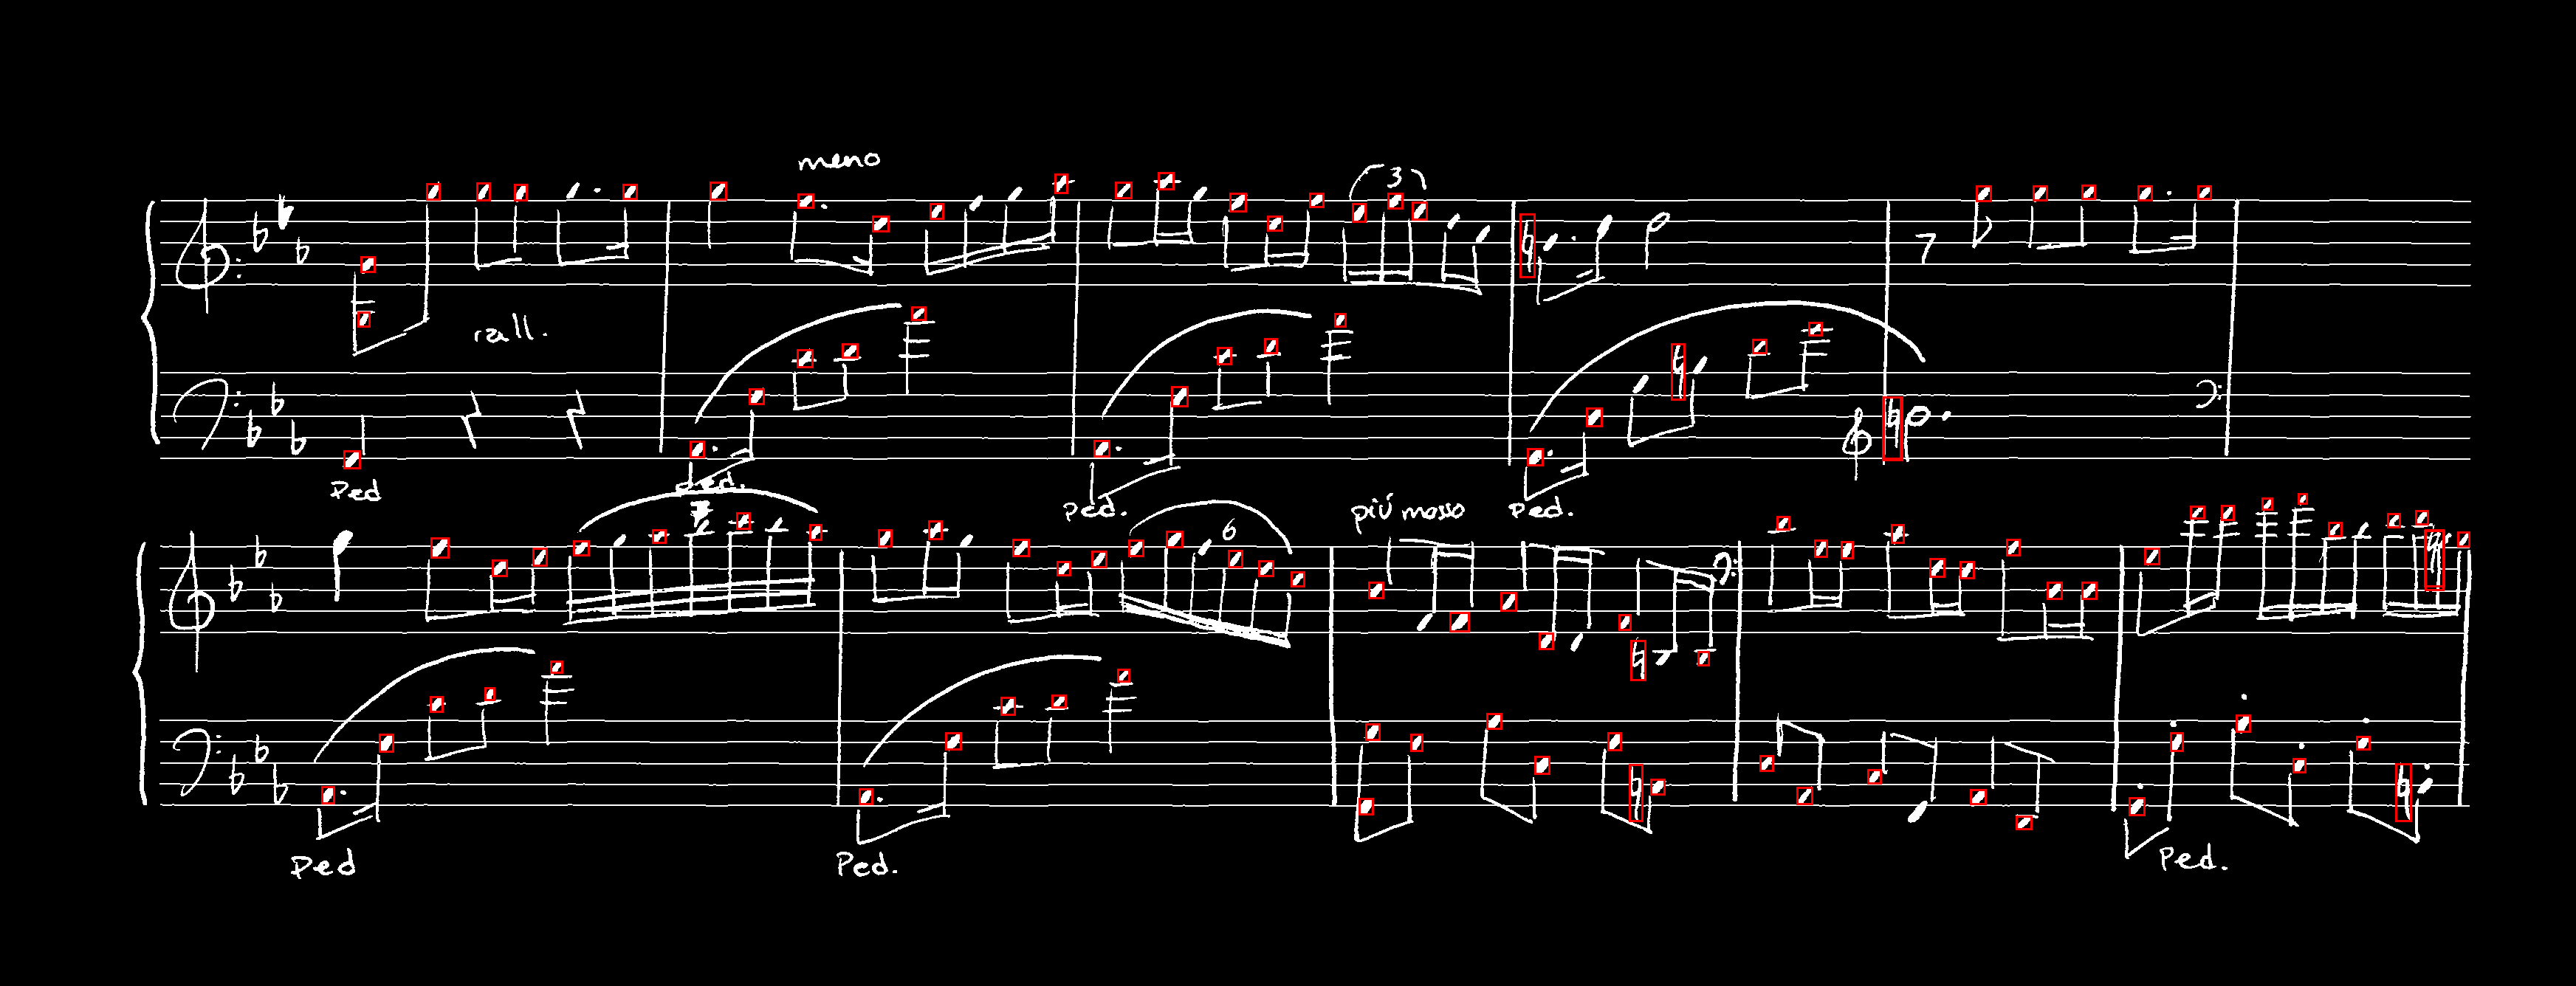

In [21]:
image_index = 0
#model = torch.load('all_objects_0151.pt')
model.eval()
if torch.cuda.is_available():
  torch.cuda.synchronize()
#image = list(img.to(torch.device('cuda')) for img in image)
image, target = hacky_dataset[image_index]
image = list(img.to(torch.device('cuda')) for img in image)
detections = model(image)

#model.eval()
#if torch.cuda.is_available():
#  torch.cuda.synchronize()
#image, target = next(iter(data_loader_test))
#image = list(img.to(torch.device('cuda')) for img in image)
#detections = model(image)
visualize_bboxes(image[0], detections[0], threshold=0.0)

In [26]:
detections[0]['boxes'].shape
#torch.sum(detections[0]['labels']==1)

torch.Size([0, 4])

In [22]:
# Example save everything
SAVE_ENTIRE_MODEL = "all_objects_0151.pt"

torch.save(model, SAVE_ENTIRE_MODEL)

In [ ]:
# 15 epochs, Adam, lr=0.001, *0.1 every 5 epochs, 0.135 mAP with custom aspect ratios
# 15 epochs, Adam, lr=0.001, *0.1 every 5 epochs, 0.113 mAP with default aspect ratios
# 50 epochs, Adam, Lr=0.001, *0.1 every 10 epochs, 0.146 mAP with custom aspect ratios